In [22]:
%matplotlib inline
import numpy as np
import scipy
import scipy.integrate

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
from pydmd import DMD


import torch
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

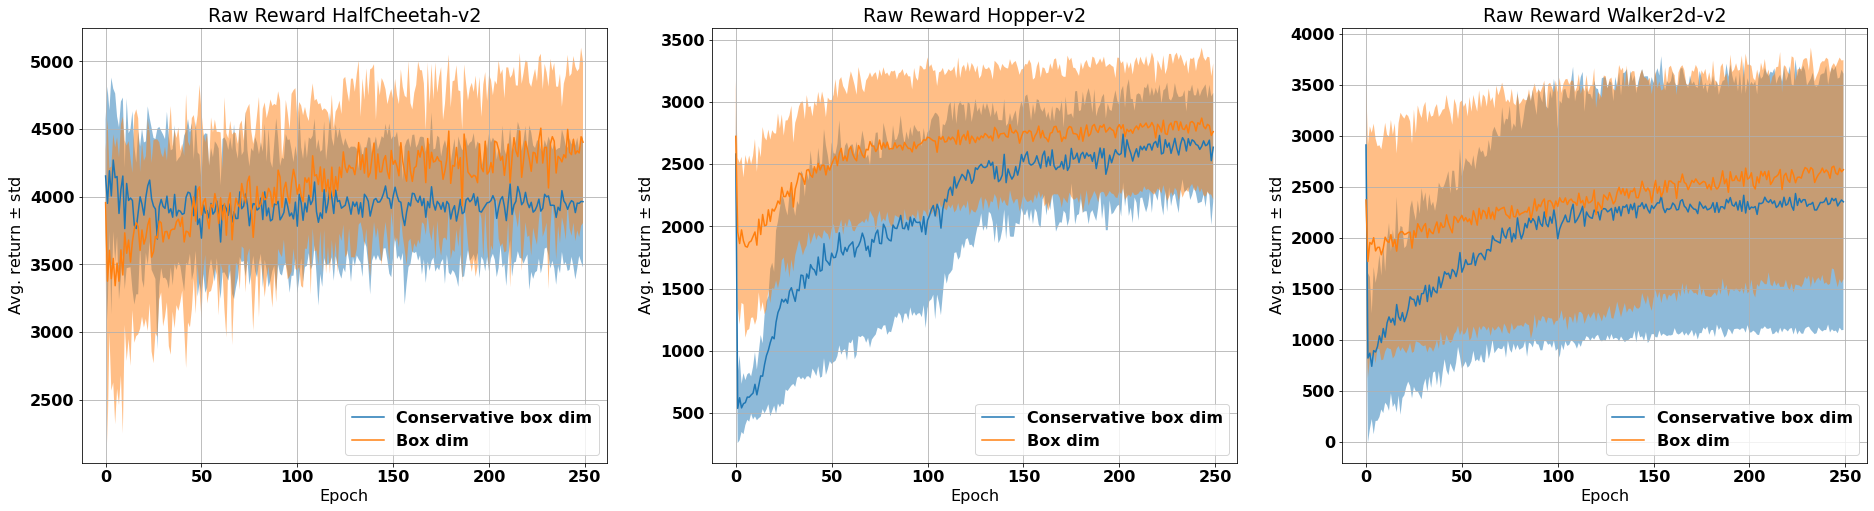

In [23]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]
init_names = ["identity", "madodiv", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    

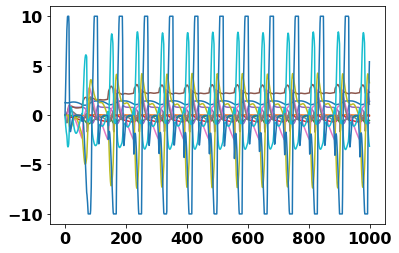

In [79]:
env_name = "Hopper-v2"
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

obs, acts, rews, _  = do_rollout(env, policy_dict['mdim_div'][5])
plt.plot(obs);

In [80]:
snapshots = []
for ob in obs:
    snapshots.append(np.array(ob))

In [96]:
dmd = DMD(svd_rank=17, tlsq_rank=17, exact=True, opt=True)
dmd.fit(snapshots)

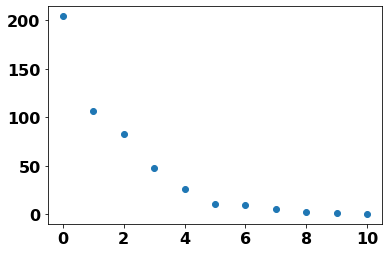

In [97]:
fig = plt.plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T), 'o')

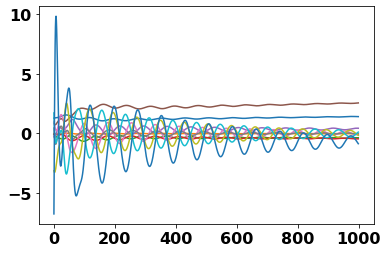

In [98]:
plt.plot(dmd.reconstructed_data.T);

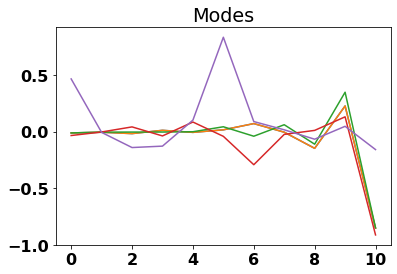

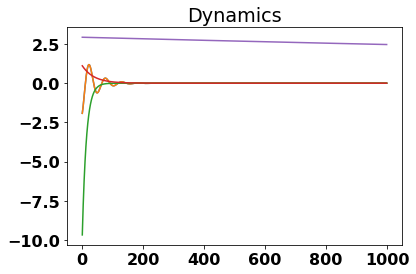

In [91]:
for mode in dmd.modes.T:
    plt.plot(mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('Dynamics')
plt.show()

TypeError: Dimensions of C (1000, 11) are incompatible with X (65) and/or Y (129); see help(pcolor)

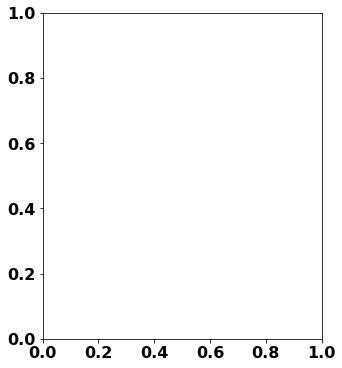

In [92]:
fig = plt.figure(figsize=(17,6))

for n, mode, dynamic in zip(range(131, 133), dmd.modes.T, dmd.dynamics):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)
    
plt.subplot(133)
plt.pcolor(xgrid, tgrid, dmd.reconstructed_data.T.real)
plt.colorbar()

plt.show()

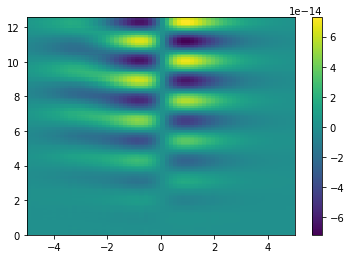

In [9]:
plt.pcolor(xgrid, tgrid, (X-dmd.reconstructed_data.T).real)
fig = plt.colorbar()